# Applies Deep Learning to ePodium dataset for prediction of Dyslexia.

#### Import Packages

In [1]:
import mne
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import ipywidgets

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Precision, BinaryAccuracy, Recall
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from functions import epodium, epodium_deep_learning, display_helper
from models.dnn import fully_connected_model
from models import transformer

import local_paths

#### Choose which processed data to use

In [2]:
processing_method_widget = ipywidgets.RadioButtons(options=['autoreject', 'ransac'], 
                                                   value='autoreject', 
                                                   description='processing:')
display(processing_method_widget)

RadioButtons(description='processing:', options=('autoreject', 'ransac'), value='autoreject')

<br>

## Preparing data iterator (Sequence) as input to the deep learning models.
https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence

#### Split processed epochs* into train and test sequence.

*In the context of electroencephalography (EEG), *epochs* are EEG segments in which an event occurs. During processing, the epochs are chosen to be 1 second in which the event occurs at 0.2s. In the context of deep learning, *epochs* are iterations over the entire training dataset.

In [3]:
if(processing_method_widget.value == "autoreject"):
    path_processed = local_paths.ePod_processed_autoreject
if(processing_method_widget.value == "ransac"):
    path_processed = local_paths.ePod_processed_ransac

train, test = epodium_deep_learning.split_train_test_datasets(path_processed)
train_sequence = epodium_deep_learning.EvokedDataIterator(train, path_processed, gaussian_noise = 1)
test_sequence = epodium_deep_learning.EvokedDataIterator(test, path_processed)

Analyzed: 228, bad: 42
186 files have enough epochs for analysis.
The dataset is split up into 138 train and 48 test experiments


<br>

## Deep Learning

The data is an *evoked* or *ERP* from a participant in the ePodium experiment. 60 EEG signals were averaged from -0.2 to +0.8 seconds after onset of an event. This is done for each of the 12 event types seperately.

__dimensions__: 
+ x (batches, timesteps, channels)
+ y (batches, labels)

__labels__: 
+ (Sex, At risk of dyslexia, first standard, standard, deviant)


#### Choose Deep Learning model

TODO check all trained models

In [4]:
model_widget = ipywidgets.RadioButtons(options=['fully_connected', 'transformer', 'new_transformer', 'new_transformer_noise'],
                                       value='new_transformer_noise', 
                                       description='Models:')
display(model_widget)

RadioButtons(description='Models:', index=3, options=('fully_connected', 'transformer', 'new_transformer', 'ne…

#### Train model

In [5]:
# Paths to save model info
base_path = os.path.join(local_paths.models, model_widget.value)
path_history = base_path + "_history.npy"
path_model = base_path + "_model"
path_testset = base_path + "_testset.txt"
path_weights = base_path + "_weights.h5"

if(os.path.exists(path_model)):
    print(f"Model: '{model_widget.value}' already exist. Delete this model first or ")    
else:
    print(f"Create model: {model_widget.value}")

    # Save validation-set for future testing
    with open(path_testset, 'w') as f:
        for participant in test:
            f.write(participant + '\n')

    # Instantiate model
    if(model_widget.value == "fully_connected"):
        model = fully_connected_model()
    elif(model_widget.value == "transformer"):
        model = transformer.TransformerModel()
    elif(model_widget.value == "new_transformer_noise"):
        model = transformer.TransformerModel()

    model.compile(optimizer=Adam(learning_rate=2e-5), loss=BinaryCrossentropy(), metrics=[Precision(), BinaryAccuracy(), Recall()])
    checkpointer = ModelCheckpoint(filepath = path_weights, monitor='val_loss', verbose=1, save_weights_only=True, save_best_only=True)
    #reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.7, verbose=1)

    # Fit model
    history = model.fit(x=train_sequence, validation_data=test_sequence, epochs=100, callbacks=[checkpointer]) # reduce_lr

    np.save(path_history, history.history)
    model.save(path_model)

Create model: new_transformer_noise


2022-09-09 23:15:47.632888: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-09 23:15:47.679408: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-09 23:15:47.679786: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-09 23:15:47.683008: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Epoch 1/100
18/18 [==============================] - ETA: 0s - loss: 1.4915 - precision: 0.5071 - binary_accuracy: 0.4980 - recall: 0.5097 
Epoch 1: val_loss improved from inf to 0.69713, saving model to /volume-ceph/floris_storage/models/new_transformer_noise_weights.h5
18/18 [==============================] - 607s 35s/step - loss: 1.4915 - precision: 0.5071 - binary_accuracy: 0.4980 - recall: 0.5097 - val_loss: 0.6971 - val_precision: 0.5208 - val_binary_accuracy: 0.5208 - val_recall: 1.0000
Epoch 2/100
18/18 [==============================] - ETA: 0s - loss: 1.5687 - precision: 0.4978 - binary_accuracy: 0.4884 - recall: 0.5256
Epoch 2: val_loss did not improve from 0.69713
18/18 [==============================] - 205s 11s/step - loss: 1.5687 - precision: 0.4978 - binary_accuracy: 0.4884 - recall: 0.5256 - val_loss: 0.6986 - val_precision: 0.5208 - val_binary_accuracy: 0.5208 - val_recall: 1.0000
Epoch 3/100
18/18 [==============================] - ETA: 0s - loss: 1.5193 - precision:

INFO:tensorflow:Assets written to: /volume-ceph/floris_storage/models/new_transformer_noise_model/assets


INFO:tensorflow:Assets written to: /volume-ceph/floris_storage/models/new_transformer_noise_model/assets


#### Show Training History

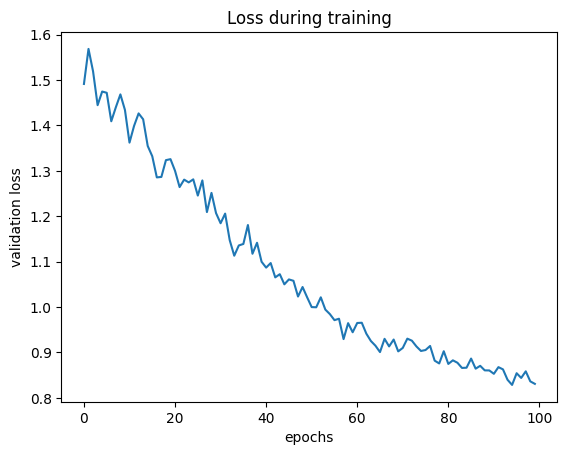

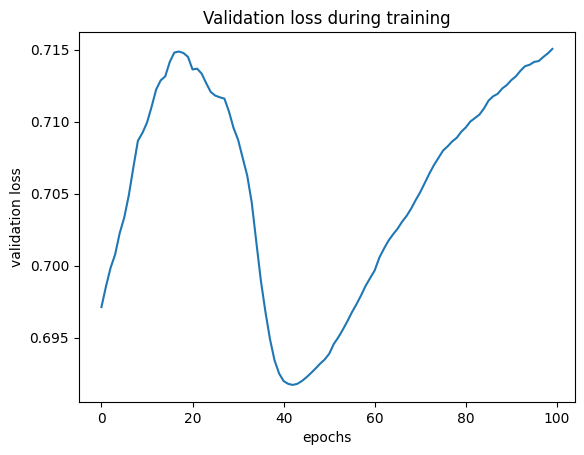

In [6]:
display_helper.show_plot(x = range(len(history.history['loss'])), y = history.history['loss'] ,xlabel = "epochs", ylabel = "validation loss", title = "Loss during training")
display_helper.show_plot(x = range(len(history.history['loss'])), y = history.history['val_loss'] ,xlabel = "epochs", ylabel = "validation loss", title = "Validation loss during training")

In [7]:
history.history

{'loss': [1.4915108680725098,
  1.568682074546814,
  1.5193123817443848,
  1.4447802305221558,
  1.4747886657714844,
  1.4720485210418701,
  1.4093073606491089,
  1.4400877952575684,
  1.4685235023498535,
  1.4343012571334839,
  1.3622560501098633,
  1.3990004062652588,
  1.4266482591629028,
  1.4136383533477783,
  1.3549408912658691,
  1.3322113752365112,
  1.2856805324554443,
  1.2867302894592285,
  1.3236603736877441,
  1.3258720636367798,
  1.3001399040222168,
  1.2643541097640991,
  1.280750036239624,
  1.2746672630310059,
  1.28135085105896,
  1.2456578016281128,
  1.279020071029663,
  1.2092691659927368,
  1.2515562772750854,
  1.207045555114746,
  1.1846861839294434,
  1.2059142589569092,
  1.1475681066513062,
  1.113176941871643,
  1.1357461214065552,
  1.1390540599822998,
  1.1807912588119507,
  1.1174811124801636,
  1.1416456699371338,
  1.0998560190200806,
  1.0869488716125488,
  1.0969898700714111,
  1.0654674768447876,
  1.0724413394927979,
  1.050142526626587,
  1.060939